In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [3]:
df = pd.read_csv("data/my_horizon_data_all.csv", dtype={"subject": str})

# files = [
#     "data/my_horizon_data.csv",
#     "data/my_horizon_data_0919.csv",
# ]
# df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [4]:
# df = df.head(5000)  # For quicker testing !!!!! REMEBER TO RMOVE IT!!!!!!

In [5]:
num_subjects = df["subject"].nunique()
print("Number of unique subjects:", num_subjects)

Number of unique subjects: 1384


In [6]:
# # boundary flag
# df['boundary'] = (df['block'] != df.groupby('subject')['block'].shift(1)).astype(int)
# print(df[['subject', 'block', 'boundary']].head(10))

In [7]:


seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

subj_onehot = pd.get_dummies(df['subject'], prefix='subj')
df_static = pd.concat([df[static_features], subj_onehot], axis=1)

X_seq = df[seq_features]
X_static = df_static
y = df[target]

# split based on subjects
subjects = df['subject'].unique()
train_subj, test_subj = train_test_split(subjects, test_size=0.2, random_state=42)

train_mask = df['subject'].isin(train_subj)
test_mask  = df['subject'].isin(test_subj)

X_seq_train = df.loc[train_mask, seq_features]
X_seq_test  = df.loc[test_mask, seq_features]

X_static_train = df_static.loc[train_mask]
X_static_test  = df_static.loc[test_mask]

y_train = y[train_mask]
y_test  = y[test_mask]

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()


# separate numeric static vs one-hot
onehot_cols = [c for c in X_static.columns if c.startswith('subj_')]

scaler = StandardScaler()

X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)

# X_static_train = scaler.fit_transform(X_static_train)
# X_static_test = scaler.transform(X_static_test)
X_static_train_num = scaler.fit_transform(X_static_train[static_features])
X_static_test_num  = scaler.transform(X_static_test[static_features])

# keep one-hot untouched
X_static_train_oh = X_static_train[onehot_cols].to_numpy()
X_static_test_oh  = X_static_test[onehot_cols].to_numpy()

--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
1  67.0  0.0  57.0  1.0  56.0  0.0  50.0  1.0
2  37.0  1.0  48.0  0.0  23.0  0.0  39.0  1.0
3  58.0  1.0  51.0  0.0  28.0  0.0  47.0  1.0
4   4.0  1.0  30.0  0.0  11.0  1.0  37.0  0.0
   gameLength  uc  subj_0  subj_1  subj_100  subj_1000  subj_1001  \
0           6   1    True   False     False      False      False   
1           6   0    True   False     False      False      False   
2           6   0    True   False     False      False      False   
3           1   0    True   False     False      False      False   
4           1   0    True   False     False      False      False   

   subj_1001.0_TMS  subj_1002  subj_1002.0_TMS  ...  subj_990  subj_991  \
0            False      False            False  ...     False     False   
1            False      False            False  ...     False     False   
2            False      False            False  ...     Fal

In [8]:
SEQ_LEN = seq_features.__len__() // 4 
print(f"SEQ_LEN: {SEQ_LEN}")
STATIC_LEN = X_static_train.shape[1]
print(f"STATIC_LEN: {STATIC_LEN}")

SEQ_LEN: 2
STATIC_LEN: 1386


In [9]:
feature_order_test = np.array(seq_features).reshape(-1, 4, SEQ_LEN)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [10]:
print(X_seq_train.shape)
print(X_seq_test.shape)
print(type(X_seq_train))
print(type(y_train))

(136652, 8)
(34333, 8)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [11]:
# # reshape to (num_samples, time_steps, features)
# X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
# print(X_seq_train.shape)
# print(type(X_seq_train))
# print(X_seq_train[0])
# X_seq_test = X_seq_test.reshape(-1, 4, SEQ_LEN)
# print(X_seq_test.shape)
# print(type(X_seq_test))

In [12]:
print(X_static_train_num[:, np.newaxis, :])

[[[ 9.99078375e-01  1.37538975e+00]]

 [[ 9.99078375e-01 -6.74679601e-04]]

 [[ 9.99078375e-01 -6.74679601e-04]]

 ...

 [[-1.00092248e+00 -6.74679601e-04]]

 [[-1.00092248e+00 -1.37673911e+00]]

 [[-1.00092248e+00  1.37538975e+00]]]


In [13]:
X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
X_seq_test  = X_seq_test.reshape(-1, 4, SEQ_LEN)


# Repeat numeric static info across 4 time steps, and append to sequential inputs
X_static_train_num_rep = np.repeat(X_static_train_num[:, np.newaxis, :], 4, axis=1)
X_static_test_num_rep  = np.repeat(X_static_test_num[:, np.newaxis, :], 4, axis=1)

X_seq_train = np.concatenate([X_seq_train, X_static_train_num_rep], axis=2)
X_seq_test  = np.concatenate([X_seq_test, X_static_test_num_rep], axis=2)

# Final static input = subject one-hot only
X_static_train = X_static_train_oh
X_static_test  = X_static_test_oh

print("Final shapes:")
print("X_seq_train:", X_seq_train.shape, 'example', X_seq_train[0])
print("X_static_train:", X_static_train.shape)
print("y_train:", y_train.shape)

Final shapes:
X_seq_train: (136652, 4, 4) example [[-0.44340398 -1.03825727  0.99907837  1.37538975]
 [-0.26885783  0.99938183  0.99907837  1.37538975]
 [-0.49591546  1.03400207  0.99907837  1.37538975]
 [-1.84556152  1.00375379  0.99907837  1.37538975]]
X_static_train: (136652, 1384)
y_train: (136652,)


convert to tensor for pytorch

In [14]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [15]:
block_counts = df.groupby('subject')['block'].nunique()
print("Unique block counts:", block_counts.unique())

Unique block counts: [160 128 121 120 125 320 224 192 134 129 147 100  82 106 123 163 157 149
  90 137 118 102  92  94  51  75  98  74  25  85  89 119  93  62  69 104
  86  88  80  76  59 109  53  83 113  96 101 103  72  68  99  58  95  78
  61 107  35  87  79  14]


In [16]:
# train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=False)
# test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [17]:
# Create index mapping *within* train/test subsets
train_subjects_series = df.loc[train_mask, 'subject'].reset_index(drop=True)
test_subjects_series  = df.loc[test_mask, 'subject'].reset_index(drop=True)

# Now build mapping of subject -> tensor-relative indices
train_subject_indices = {
    subj: np.where(train_subjects_series == subj)[0]
    for subj in train_subj
}
test_subject_indices = {
    subj: np.where(test_subjects_series == subj)[0]
    for subj in test_subj
}

# Make per-subject tensors (now indices are valid)
train_groups = [
    (subj,
     X_seq_train_tensor[idx],
     X_static_train_tensor[idx],
     y_train_tensor[idx])
    for subj, idx in train_subject_indices.items()
]

test_groups = [
    (subj,
     X_seq_test_tensor[idx],
     X_static_test_tensor[idx],
     y_test_tensor[idx])
    for subj, idx in test_subject_indices.items()
]


In [18]:
class SubjectLoader:
    def __init__(self, groups):
        self.groups = groups
    def __iter__(self):
        for subj, X_seq, X_static, y in self.groups:
            yield subj, X_seq, X_static, y
    def __len__(self):
        return len(self.groups)

train_loader = SubjectLoader(train_groups)
test_loader  = SubjectLoader(test_groups)


In [19]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_idx = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_idx = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = X_seq_test_tensor[h1_idx]
X_seq_test_h6 = X_seq_test_tensor[h6_idx]

X_static_test_h1 = X_static_test_tensor[h1_idx]
X_static_test_h6 = X_static_test_tensor[h6_idx]

y_test_h1 = y_test_tensor[h1_idx]
y_test_h6 = y_test_tensor[h6_idx]

test_groups_h1 = [("H1", X_seq_test_h1, X_static_test_h1, y_test_h1)]
test_groups_h6 = [("H6", X_seq_test_h6, X_static_test_h6, y_test_h6)]

test_loader_h1 = SubjectLoader(test_groups_h1)
test_loader_h6 = SubjectLoader(test_groups_h6)

In [20]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

print(h1_idx.shape, X_seq_test_tensor.shape)
print("Number of H1 games:", h1_idx.sum().item())
print("Number of H6 games:", h6_idx.sum().item())

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([34333]) torch.Size([34333, 4, 4])
Number of H1 games: 17170
Number of H6 games: 17163


In [21]:
SEQ_LEN = 4

# Model

In [22]:
class RNNbeta(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, hidden_size=64, output_size=2):
        super(RNNbeta, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(seq_input_size, hidden_size, batch_first=True)
        self.logit_beta = nn.Parameter(torch.tensor(0.0))  # initialize logit(0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, h=None):
        if h is not None:
            beta = torch.sigmoid(self.logit_beta)  # constrain between 0 and 1
            h = beta * h.detach()
        gru_out, h_n = self.rnn(seq_x, h)
        h_n = h_n.squeeze(0)
        
        output = self.fc(h_n)
        return output, h_n.unsqueeze(0)


In [23]:
class LSTMbeta(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, hidden_size=64, output_size=2):
        super(LSTMbeta, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True)
        self.logit_beta = nn.Parameter(torch.tensor(0.0))  # initialize logit(0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, h=None):
        if h is not None:
            beta = torch.sigmoid(self.logit_beta)  # constrain between 0 and 1
            h = beta * h.detach()
        lstm_out, (h_n, c_n) = self.lstm(seq_x)
        h_n = h_n.squeeze(0)
        
        output = self.fc(h_n)
        return output, h_n.unsqueeze(0)

In [24]:
class GRU(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, hidden_size=64, output_size=2):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, h=None):
        gru_out, h_n = self.gru(seq_x, h)
        h_n = h_n.squeeze(0)
        
        output = self.fc(h_n)
        return output, h_n.unsqueeze(0)

In [25]:
class GRUbeta(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, hidden_size=64, output_size=2):
        super(GRUbeta, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.logit_beta = nn.Parameter(torch.tensor(0.0))  # initialize logit(0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, h=None):
        if h is not None:
            beta = torch.sigmoid(self.logit_beta)  # constrain between 0 and 1
            h = beta * h.detach()
        gru_out, h_n = self.gru(seq_x, h)
        h_n = h_n.squeeze(0)
        
        output = self.fc(h_n)
        return output, h_n.unsqueeze(0)

In [26]:
class TinyGRUbeta(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, hidden_size=2, output_size=2):
        super(TinyGRUbeta, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.logit_beta = nn.Parameter(torch.tensor(0.0))  # initialize logit(0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, h=None):
        if h is not None:
            beta = torch.sigmoid(self.logit_beta)  # constrain between 0 and 1
            h = beta * h.detach()
        gru_out, h_n = self.gru(seq_x, h)
        h_n = h_n.squeeze(0)
        
        output = self.fc(h_n)
        return output, h_n.unsqueeze(0)

# train / eval

In [27]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0  # total number of games (not batches)

    BATCH_GAMES = 32  # tune this as needed

    for subj_id, seqs, statics, labels in train_loader:
        h = None
        subj_loss = 0.0  # ✅ initialize per subject

        for i in range(0, len(seqs), BATCH_GAMES):
            x_batch = seqs[i:i+BATCH_GAMES].to(device)
            y_batch = labels[i:i+BATCH_GAMES].to(device)

            if h is not None and h.size(1) != len(x_batch):
                h = torch.zeros(1, len(x_batch), model.hidden_size, device=device)

            preds, h = model(x_batch, h)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            h = h.detach()


            subj_loss += loss.item() * len(x_batch)  # scale by batch size
            correct += (preds.argmax(dim=1) == y_batch).sum().item()
            total += len(x_batch)

        total_loss += subj_loss

    avg_loss = total_loss / total
    accuracy = correct / total
    return accuracy, avg_loss


def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total_loss = 0.0
    total = 0

    with torch.no_grad():
        for subj_id, seqs, statics, labels in test_loader:
            h = None  # reset per subject

            seqs = seqs.to(device)
            labels = labels.to(device)

            for i in range(len(seqs)):
                x_seq = seqs[i].unsqueeze(0)
                y_true = labels[i].unsqueeze(0)

                preds, h = model(x_seq, h)
                loss = criterion(preds, y_true)

                total_loss += loss.item()
                correct += (preds.argmax(dim=1) == y_true).sum().item()
                total += 1

    avg_loss = total_loss / total
    accuracy = correct / total
    return accuracy, avg_loss

In [28]:
def train_and_evaluate(model, train_loader, criterion, optimizer, device, epochs):
    train_loss_prog, train_acc_prog = [], []
    test_loss_prog, test_acc_prog = [], []
    test_acc_h1_prog, test_loss_h1_prog = [], []
    test_acc_h6_prog, test_loss_h6_prog = [], []

    epochs_without_improvement = 0
    best_loss = float('inf')
    PATIENCE = 5
    final_epoch = epochs

    for epoch in range(epochs):
        # ----- TRAIN -----
        train_acc, train_loss = train(model, train_loader, criterion, optimizer, device)

        # ----- EVALUATE -----
        test_acc, test_loss = test(model, test_loader, criterion, device)
        test_acc_h1, test_loss_h1 = test(model, test_loader_h1, criterion, device)
        test_acc_h6, test_loss_h6 = test(model, test_loader_h6, criterion, device)

        # ----- LOG -----
        if (epoch + 1) % 10 == 0 or epoch == 0:
            # If your model returns β (GRUβ)
            if hasattr(model, "logit_beta"):
                beta_val = torch.sigmoid(model.logit_beta).item()
                print(f"Epoch {epoch+1}: Loss: {test_loss:.4f} | overall: {test_acc:.4f} | H1 {test_acc_h1:.4f} | H6 {test_acc_h6:.4f} | β={beta_val:.3f}")
            else:
                print(f"Epoch {epoch+1}: Loss: {test_loss:.4f} | overall: {test_acc:.4f} | H1 {test_acc_h1:.4f} | H6 {test_acc_h6:.4f}")

        # ----- STORE PROGRESS -----
        train_acc_prog.append(train_acc)
        train_loss_prog.append(train_loss)

        test_loss_prog.append(test_loss)
        test_acc_prog.append(test_acc)

        test_acc_h1_prog.append(test_acc_h1)
        test_loss_h1_prog.append(test_loss_h1)
        test_acc_h6_prog.append(test_acc_h6)
        test_loss_h6_prog.append(test_loss_h6)

        # ----- EARLY STOPPING -----
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement > PATIENCE:
            print(f"Early stopping triggered: epoch {epoch+1}, best_loss {best_loss:.4f}")
            final_epoch = epoch + 1
            break

    return {
        "train_loss_prog": train_loss_prog,
        "train_acc_prog": train_acc_prog,
        "test_loss_prog": test_loss_prog,
        "test_acc_prog": test_acc_prog,
        "test_acc_h1_prog": test_acc_h1_prog,
        "test_loss_h1_prog": test_loss_h1_prog,
        "test_acc_h6_prog": test_acc_h6_prog,
        "test_loss_h6_prog": test_loss_h6_prog,
        "final_epoch": final_epoch
    }


# running experiment

## multiple models

In [29]:
model_dict = {
    "LSTM": LSTMbeta().to(device),
    "RNN": RNNbeta().to(device),
    "GRU": GRU().to(device),
    "GRUbeta": GRUbeta().to(device),
    "TinyGRU": TinyGRUbeta().to(device),
}

In [30]:
epochs = 100
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train_and_evaluate(model, train_loader, criterion, optimizer, device, epochs=epochs)
    if hasattr(model, "logit_beta"):
        beta_val = torch.sigmoid(model.logit_beta).item()
        print(f"{model_name}: final learned β = {beta_val:.3f}")
    model_dict[model_name] = {
        "model": model,
        **history   # unpack dictionary contents into this model’s record
    }
    # torch.save(model.state_dict(), f"model_weights_crossgame_{model_name}.pth")



Training model: LSTM
Epoch 1: Loss: 0.5118 | overall: 0.7696 | H1 0.8107 | H6 0.7285 | β=0.500
Epoch 10: Loss: 0.4981 | overall: 0.7754 | H1 0.8149 | H6 0.7359 | β=0.500
Early stopping triggered: epoch 19, best_loss 0.4974
LSTM: final learned β = 0.500

Training model: RNN
Epoch 1: Loss: 0.5216 | overall: 0.7590 | H1 0.7951 | H6 0.7221 | β=0.293
Epoch 10: Loss: 0.5067 | overall: 0.7698 | H1 0.8071 | H6 0.7329 | β=0.160
Early stopping triggered: epoch 18, best_loss 0.5065
RNN: final learned β = 0.173

Training model: GRU
Epoch 1: Loss: 0.5194 | overall: 0.7635 | H1 0.8028 | H6 0.7247
Epoch 10: Loss: 0.5132 | overall: 0.7633 | H1 0.8021 | H6 0.7276
Early stopping triggered: epoch 12, best_loss 0.5085

Training model: GRUbeta
Epoch 1: Loss: 0.5149 | overall: 0.7677 | H1 0.8055 | H6 0.7279 | β=0.293
Epoch 10: Loss: 0.4993 | overall: 0.7747 | H1 0.8128 | H6 0.7357 | β=0.113
Epoch 20: Loss: 0.5003 | overall: 0.7733 | H1 0.8129 | H6 0.7333 | β=0.169
Early stopping triggered: epoch 21, best_l

In [31]:
dump_history = {}

for model_name, content in model_dict.items():
    # content = {"model": <model_object>, "train_acc": ..., "test_acc": ..., ...}
    filtered = {k: v for k, v in content.items() if k != "model"}
    dump_history[model_name] = filtered
# store the outputs 
import json
with open("output_cross_games.json", "w") as f:
    json.dump(dump_history, f)

# plotting

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import to_rgb

## multiple models

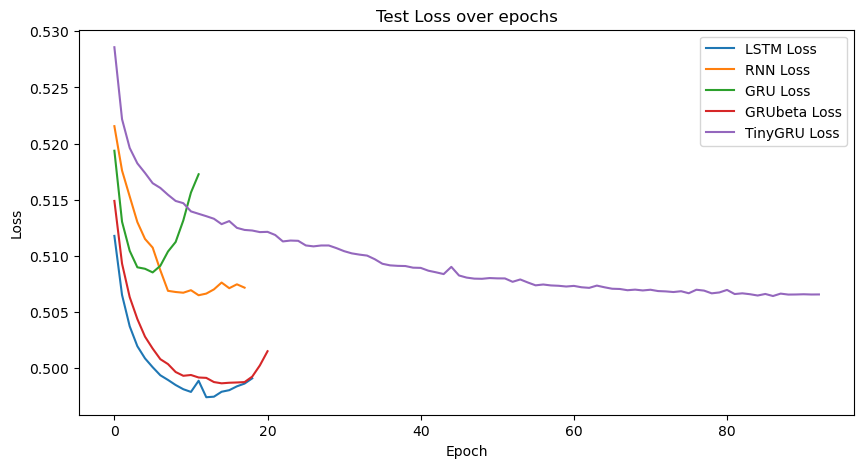

In [33]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
for model_name, data in model_dict.items():
    loss_prog = data["test_loss_prog"]
    final_epoch = data["final_epoch"]
    plt.plot(range(final_epoch), loss_prog, label=f'{model_name} Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over epochs')
plt.legend()
plt.show()

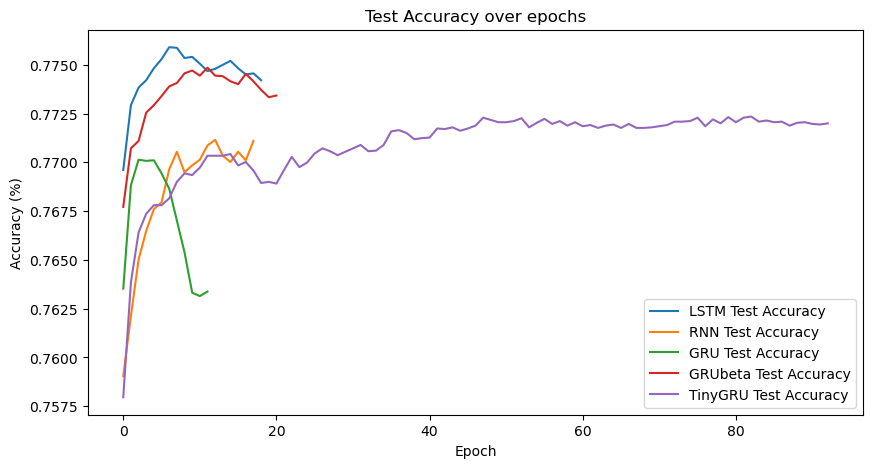

In [34]:
# plot testing accuracy
plt.figure(figsize=(10, 5))
for model_name, data in model_dict.items():
    acc_prog = data["test_acc_prog"]
    final_epoch = data["final_epoch"]
    plt.plot(range(final_epoch), acc_prog, label=f'{model_name} Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs')
plt.legend()
plt.show()


In [35]:
n = len(model_dict)

# Two color ramps
blue_cmap = plt.get_cmap('Blues')
red_cmap  = plt.get_cmap('Reds')

# helper to pick a shade between lo..hi in the colormap
def shade(cmap, i, n, lo=0.35, hi=0.85):
    if n <= 1:
        t = (lo+hi)/2
    else:
        t = lo + (hi - lo) * (i / (n - 1))
    return cmap(t)

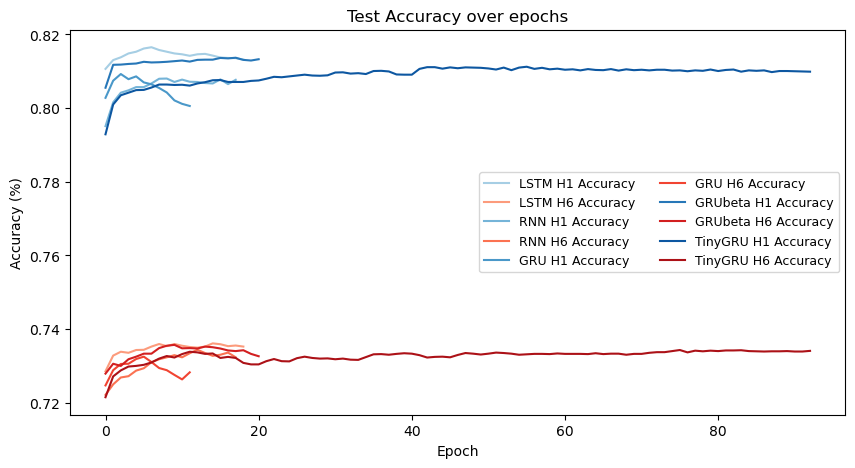

In [36]:
# plot testing accuracy h1 vs h6
plt.figure(figsize=(10, 5))
for i, (model_name, data) in enumerate(model_dict.items()):
    acc_h1_prog = data["test_acc_h1_prog"]
    acc_h6_prog = data["test_acc_h6_prog"]
    final_epoch = data["final_epoch"]
    plt.plot(range(final_epoch), acc_h1_prog, label=f'{model_name} H1 Accuracy', color=shade(blue_cmap, i, n))
    plt.plot(range(final_epoch), acc_h6_prog, label=f'{model_name} H6 Accuracy', color=shade(red_cmap, i, n))
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs')
plt.legend(
    ncol=2,      
    fontsize=9, 
)
plt.show()

## error bar

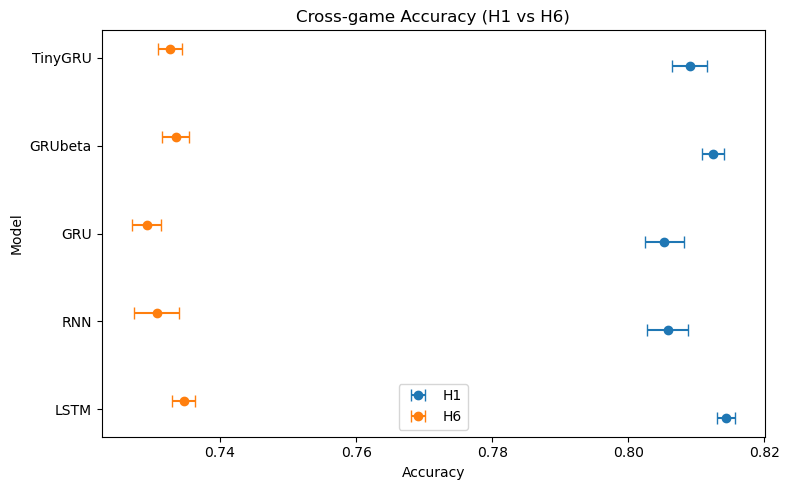

In [37]:
h1_means = []
h6_means = []

h1_stds = []
h6_stds = []

for model_name, data in model_dict.items():
    acc_h1 = data["test_acc_h1_prog"]
    acc_h6 = data["test_acc_h6_prog"]

    h1_means.append(np.mean(acc_h1))
    h6_means.append(np.mean(acc_h6))
    h1_stds.append(np.std(acc_h1))
    h6_stds.append(np.std(acc_h6))


names = list(model_dict.keys())
y_pos = np.arange(len(names))
fig, ax = plt.subplots(figsize=(8, 5))

# H1
ax.errorbar(h1_means, y_pos - 0.1, xerr=h1_stds, fmt='o', color='tab:blue',
            label="H1", capsize=4)

# H6
ax.errorbar(h6_means, y_pos + 0.1, xerr=h6_stds, fmt='o', color='tab:orange',
            label="H6", capsize=4)

ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.set_xlabel("Accuracy")
ax.set_ylabel("Model")
ax.set_title("Cross-game Accuracy (H1 vs H6)")
ax.legend()

plt.tight_layout()
plt.show()